In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as stats2
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import inspect
import warnings
warnings.filterwarnings('ignore')


In [3]:
df_prueba = pd.DataFrame({
"ES_NO_ES":[np.random.choice(['s','n']) for _ in range(1000)],
"sexo":[np.random.choice(['h','m']) for _ in range(1000)],
"Datos_C":[np.random.choice([0,1]) for _ in range(1000)],
"Datos_D": list(np.random.standard_normal(1000)),
"Datos_E": list(np.random.standard_normal(1000)),
"Datos_Poisson_1": list( stats.poisson.rvs(mu=4, size=1000)),
"Datos_Poisson_3": list( np.random.poisson(lam=10, size=1000)),
"Datos_F": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_G": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_cate_A": ['Grupo '+str(np.random.randint(0,6)) for _ in range(1000)],
"Datos_cate_B": ['Grupo '+str(np.random.randint(0,4)) for _ in range(1000)],

})

for i in range(1,6):
    df_prueba['Datos_E'][random.randint(0,23)]=None


for i in range(1,10):
    df_prueba['Datos_F'][random.randint(0,23)]=None

for i in range(0,11):
    df_prueba['Datos_G'][i]=None


In [4]:

class DF_exploracion(pd.DataFrame):

    def __init__(self, *args, **kw):
        super(DF_exploracion, self).__init__(*args, **kw)
        self.cuanti=pd.DataFrame
        self.cuali=pd.DataFrame
        self.dico=pd.DataFrame
        self.cate=pd.DataFrame
        self.eliminado=pd.DataFrame
        self.dummy=pd.DataFrame
        self.df=pd.DataFrame
        self.df_inputado=pd.DataFrame
        self.df_limpio=pd.DataFrame
        self.normal_cuatis=[]
        self.normal_grupos_dico=[]
        self.normal_grupos_cate=[]
        self.discreta=[]
        self.stingg=[]
        
        
        self.porcentaje_nulos_permitido=0.6

    def variables(self):

        dico=[]
        cuantis=[]
        categori=[]
        eliminar=[]
        

        for i in self.columns: 

            try:
                datos=self[i].dropna().to_numpy()
                discreta=True
                for j in datos:
                    if (j%1 !=0):
                        discreta=False
                        break
                    else:
                        continue
                if (discreta):
                    self.discreta.append(i)
            except:
                self.stingg.append(i)

            nulos= (self[i].isnull().sum())/len(self[i])
            
            if ((len(self[i].dropna().unique())==2) and (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: DICOTOMICA"
                dico.append(i)

            elif ((len(self[i].dropna().unique())>10) and  (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CUANTITATIVA"
                cuantis.append(i)

            elif ( (len(self[i].dropna().unique())<2) or (nulos>self.porcentaje_nulos_permitido)):
                tipo_de_var=f"SOLO {len(self[i].dropna().unique())} TIPOS, NO VALE LA COLUMNA"
                eliminar.append(i)
            else:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CATEGORICA/CUANTI"
                categori.append(i)

            print (f"|  {i} \n|   - Tipo de dato: {self[i].dtype} \n|   - Valores repetidos: {tipo_de_var} \n|   - Nulos: {nulos} \n| ")

        print (f"|----------------------------------------------------------------------------------------------------\n|  TODAS: {self.columns} \n|  DICOTOMICAS: {dico} \n|  CATEGORICAS: {categori} \n|  CUANTITATIVAS: {cuantis} \n|  ELIMINAR: {eliminar}")
        print("|----------------------------------------------------------------------------------------------------")

        


        self.DF_cuantis(cuantis)
        self.DF_cualis(categori+dico)
        self.DF_dicotomica(dico)
        self.DF_categorica(categori)
        self.DF_elimiminado(eliminar)
        self.df=self
        
    def todas_col(self):
        return self.df
    
    def DF_cuantis(self,lista):
        self.cuanti=self[lista]

    def DF_elimiminado(self,lista):
        self.eliminado=self[lista]
        
    def DF_cualis(self,lista):
        self.cuali=self[lista]
        
    def DF_dicotomica(self, lista):
        self.dico=self[lista]
        
    def DF_categorica(self, lista):
        self.cate=self[lista]   



    def limpiar_aux(self):
        
        try:
            df_nuevo=pd.DataFrame
            aux1=list(self.dico.columns)
            aux=[]
            df_nuevo=pd.get_dummies(self.df, columns=aux1)
            
            for columna in df_nuevo.columns:
                for variables in list(self.dico.columns):
                    if variables in columna:
                        aux.append(columna)
                    
            self.dummy=df_nuevo[aux]
            self[aux]=df_nuevo[aux]

            # self.df=self.drop(columns=var, axis='columns')
            # self.df= self[self.columns.difference(self.dico.columns)]
            
            print("********************** self.dummy ************\n")
            print(self.dummy)
            print("\n********************** self.df o todas_las_col() ************\n")
            print(self.df)

        except:
            print("---------------------- ERROR -----------------")



    def limpiar_dummys(self):

        b=False
        lista=list(self.dico.columns)
        for ind, i in enumerate(lista):
                if (ind+1<len(lista)):
                    if( (i in lista [ind+1]) ):
                        b=True
                        break
        if b:
            nombres_nuevos=[]
            if len(lista)>2:
                for ind, i in enumerate(lista):
                    if (ind+1<len(lista)):
                        if( (i in lista [ind+1]) ):
                            nombres_nuevos.append(i.upper())
                        else:
                            nombres_nuevos.append(i)
                    else:
                        nombres_nuevos.append(i)
                        
            aux_df=self.df

            for i,j in zip(lista,nombres_nuevos):
                aux_df.rename(columns={i:j},inplace=True)
                
            self.df=aux_df
            self.dico.columns=nombres_nuevos
            
            self.limpiar_aux()
        else: 
            self.limpiar_aux()



    def estadistica_descriptiva_cuantis(self):

        print("----------------------------------------------------------------------------------------------------\nDESCRIPCIÓN")
        print (self.cuanti.describe())
        print("\n")
        print("----------------------------------------------------------------------------------------------------\nCUARTILES")
        print (self.cuanti.quantile([0.05,0.25,0.5,0.75,0.95]))
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")


        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        # df_auxiliar = self.groupby('sexo').apply(lambda x: pd.Series(shapiro(x), index=['W','P'])).reset_index()
        # print(df_auxiliar)
                
        for a in list(aux1.values):
            
            for b in list(aux.values):
                
                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                agrupado=self.groupby(a)[b]
                titulo=f"Agrupado por {a} y por {b}"
                print(titulo)
                print(agrupado.describe().reset_index())
                # df.groupby(['cat1', 'cat2'])['purchases','sales'].apply(stats.shapiro)
                print("////////////////////////// TEST DE SHAPIRO ////////////////////////////")
                aux_shapiro=(agrupado.apply(stats.shapiro))
                print(aux_shapiro)
        
                
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")


    def estadistica_descriptiva_cualis(self):

        print("\n--------------------- Variables dico ---------------------")
        print("\n")
        for i in self.dico.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")

        print("\n-------------------- Variables categoricas --------------------")
        print("\n")
        for i in self.cate.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")
        print("\n\n")

        # crosstab variables cualis con cate
        aux=list(self.cate.columns)

        a=0
        for i in aux:
            a=a+1
            if a<len(aux)/2:
                b=0
                for j in aux[:-1]:
                    b=b+1
                    if b > a:
                        print(f"*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} *********************\n ")
                        tab = pd.crosstab (index=self[i], columns=self[j])
                        x=(tab/tab.sum())
                        print(tab)
                        print("\n")
                        print(f"/////////////////// EN PROPORCION //////////////////\n")
                        print(x)
                        print("\n\n")


    def anova(self):

        aux_cate=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for i in aux_cate:
            for j in aux_cuati:
                try:
                    print(f"\n----------- ANOVA Categoria {i} y variable continua {j} ----------\n")
                    model = ols(f"{j} ~ {i}", data=self).fit()
                    a=sm.stats.anova_lm(model, typ=2)
                    print(a)
                except:
                    print(f"\n - - - - - Fallo en variable {i} y {j} - - - - - - \n")
                    continue




    def Chi(self):

        aux_dico=list(self.dico.columns)

        if len(aux_dico)>1:
            for ind, i in enumerate(aux_dico):
                for j in range(ind+1,len(aux_dico)):
                    chi, p, dof, expected = stats.chi2_contingency(pd.crosstab(self[i],self[aux_dico[j]]), correction=False)
                    print(f"\n-------------- Chi2 entre {i} y {aux_dico[j]} ----------------")
                    print(f"p: {p} \n") 
        else:
            print("******************** No suficientes argumentos ********************")





    def plot_normailidad(self):

        aux=self.cuanti.columns
        for i in aux:
            stats.probplot(self[i], dist="norm", plot=plt)
            plt.title("Probability Plot - " )
            plt.show()
    


    def plot_bigotes(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

        print("-------------- Graficas de bigotes cualitativas-------------------")
        # fig = plt.figure(figsize=(12, 8))
        
        (self.cuanti).plot(kind='box', title='Variables cuantitativas',figsize=(12, 8))
        plt.show()
        

        print("-------------- Graficas de bigotes por dicotomicas-------------------")   
        
        for a in aux1:

            # fig = plt.figure(figsize=(12, 8))
            self.boxplot(column=list(aux.values), by=a,figsize=(12, 8))
            plt.tight_layout() 
            plt.show()
        
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- Graficas de bigotes por categoricas-------------------") 

        for a in aux2:
            # fig = plt.figure(figsize=(12, 8))
            ax= self.boxplot(column=list(aux.values), by=a, figsize=(12, 8))
            # ax = sns.swarmplot(column=list(aux.values), by=a,data=self, color='#7d0013')
            plt.tight_layout() 
            plt.show()
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")

        
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")



    def plot_corr(self):

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------\n") 

        fig = plt.figure(figsize=(12, 8))
        matrix = self.cuanti.corr().round(2)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)  
        plt.show()

        print("----------------------------------------------------------------------------------------------------\n")

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def plot_barras(self):
        aux=self.cuanti.columns

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")

        print("-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------\n") 
        # fig = plt.figure(figsize=(15, 20))
        self.cuanti.plot.bar(figsize=(18, 8))
        plt.show()

        print("-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------\n") 
        for i in list(aux.values):
            fig = plt.figure(figsize=(12, 8))
            print(f"\n.............. GRAFICA DE BARRAS  DE {i} ............\n") 
            ax=self[i].plot.hist(density=True)
            self[i].plot.density(ax=ax)
            plt.show()

        print("----------------------------------------------------------------------------------------------------\n")    
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def todos_plots(self):

        self.plot_bigotes()
        self.plot_corr()
        self.plot_barras()
        self.violines()
        
        

    def violines(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        print("--------------  GRAFICA DE VIOLINES  -------------------\n") 
        sns.set(style="whitegrid")
        for i in aux2:
            for j in aux:
                ax= sns.violinplot(x=self[i], y=self[j], palette="Set2", split=True, inner="quartile",scale="count")
                plt.show()

        print("\n\n/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////\n") 
        
        for i in aux2:
            for j in aux:
                for k in aux1:
                    ax= sns.violinplot(x=self[i], y=self[j], hue=self[k],palette="Set2", split=True, inner="quartile",scale="count")
                    plt.show()


    def cross_var_cualis_con_ciantis(self):

        aux=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for k in aux_cuati:
            a=0
            for i in aux:
                a=a+1
                if a<len(aux)/2:
                    b=0
                    for j in aux[:-1]:
                        b=b+1
                        if b > a:
                            print(f"\n\n*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} con valores de {k} MEDIA *********************\n ")
                            tab = pd.crosstab (index=self[i], columns=self[j],values=self[k],aggfunc=np.mean)
                            print(tab)
                            print("\n\n")

    def nulos(self):
        aux_df=list(self.cuanti.columns)
        aux_DF=self.cuanti
        self.df_inputado=self.df
        for i in aux_df:
            nulos=aux_DF[i].isna().sum()
            total=len(aux_DF[i])
            porcentaje=nulos/total
            if ((nulos>0) and (porcentaje<self.porcentaje_nulos_permitido)):
                percen=aux_DF[i].quantile([0.2,0.8]).to_list()
                self.df_inputado[i]=aux_DF[i].apply(lambda x: ( random.randint ( round(percen[0]) , round(percen[1]) )) if pd.isna(x) else x )
                print(f"\n- Se han inputado {nulos} nulos a la variable {i} (tenía porcentaje de nulos de: {porcentaje}) \n")
            elif (porcentaje>self.porcentaje_nulos_permitido):
                print(f"\n - No se ha podido inputar a la variable {i} porque el porcentaje de nulos era de {porcentaje}\n")
                

    def normalidad(self):
        
        DataF=self.df
        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
                
        for b in list(aux.values):
            aux_shapiro=(stats.shapiro(DataF[b]))
            if(aux_shapiro.pvalue<0.05):
                print("////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////")
                print("++++++++++++++++++++++++++++  "+ b +"  ++++++++++++++++++++++++++\n")
                titulo=f"Variable cuantitativa {b} y test Shapiro < 0.05"
                print(titulo)
                print(aux_shapiro)
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")
                self.normal_cuatis.append(b)

        for a in list(aux1.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby(a)[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(aux_shapiro)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_dico.append([a,b])
                    except:
                        continue 

        for a in list(aux2.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby([a])[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO CATEGORICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(h)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_cate.append([a,b])
                    except:
                        continue 

    def detec_outlaiers(self):
        aux=list(self.cuanti.columns)
        aux_DF=self.cuanti
        for i in aux:
            z = np.abs(stats.zscore(aux_DF[i]))
            print(z)
    





    def seleccionar_distribuciones(self,familia='realall', verbose=False):
        '''
        Parameters
        ----------
        familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
            realall: distribuciones de la familia `realline` + `realplus`
            realline: distribuciones continuas en el dominio (-inf, +inf)
            realplus: distribuciones continuas en el dominio [0, +inf)
            real0to1: distribuciones continuas en el dominio [0,1]
            discreta: distribuciones discretas
            
        verbose : bool
            Si se muestra información de las distribuciones seleccionadas
            (the default `False`)
        '''
    
        distribuciones = [getattr(stats,d) for d in dir(stats) \
                        if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
        
        exclusiones = ['levy_stable', 'vonmises']
        distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
                
        dominios = {
            'realall' : [-np.inf, np.inf],
            'realline': [np.inf,np.inf],
            'realplus': [0, np.inf],
            'real0to1': [0, 1], 
            'discreta': [None, None],
        }

        distribucion = []
        tipo = []
        dominio_inf = []
        dominio_sup = []

        for dist in distribuciones:
            distribucion.append(dist.name)
            tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
            dominio_inf.append(dist.a)
            dominio_sup.append(dist.b)
        
        info_distribuciones = pd.DataFrame({
                                'distribucion': distribucion,
                                'tipo': tipo,
                                'dominio_inf': dominio_inf,
                                'dominio_sup': dominio_sup
                            })

        info_distribuciones = info_distribuciones \
                            .sort_values(by=['dominio_inf', 'dominio_sup'])\
                            .reset_index(drop=True)
        
        if familia in ['realall', 'realline', 'realplus', 'real0to1']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
            condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                        (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
            info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
            
        if familia in ['discreta']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
            
        seleccion = [dist for dist in distribuciones \
                    if dist.name in info_distribuciones['distribucion'].values]
        
        
        if verbose:
            print("---------------------------------------------------")
            print("       Distribuciones seleccionadas                ")
            print("---------------------------------------------------")
            with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                print(info_distribuciones)
        
        return seleccion


    def plot_multiple_distribuciones(self, nombre_distribuciones):

        aux=list(self.cuanti.columns)
        fig, ax = plt.subplots(figsize=(15,15))

        for i in aux:
            x=self[i]
            if ax is None:
                fig, ax = plt.subplots(figsize=(7,4))
                
            ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
            ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
            ax.set_title('Ajuste distribuciones')
            ax.set_xlabel('x')
            ax.set_ylabel('Densidad de probabilidad')
            
            for nombre in nombre_distribuciones:
                
                distribucion = getattr(stats, nombre)

                parametros = distribucion.fit(data=x)

                nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                    if not p=='x'] + ["loc","scale"]
                parametros_dict = dict(zip(nombre_parametros, parametros))

                log_likelihood = distribucion.logpdf(x, *parametros).sum()

                aic = -2 * log_likelihood + 2 * len(parametros)
                bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                x_hat = np.linspace(min(x), max(x), num=100)
                y_hat = distribucion.pdf(x_hat, *parametros)
                ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
            ax.legend()
            plt.show()
        
        

    def comparar_distribuciones_caunti_cont(self, ordenar='aic', verbose=False):

            '''
            resultados: data.frame
                distribucion: nombre de la distribución.
                log_likelihood: logaritmo del likelihood del ajuste.
                aic: métrica AIC.
                bic: métrica BIC.
                n_parametros: número de parámetros de la distribución de la distribución.
                parametros: parámetros del tras el ajuste
                
            Raises
            ------
            Exception
                Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
                o 'discreta'.
                
            Notes
            -----
            '''
            aux=list(self.cuanti.columns)
            
            for i in aux:
                print(f"\n ******************** Variable: {i} ******************** \n")
                x=self[i]
                distribuciones = self.seleccionar_distribuciones(familia='realall',verbose=verbose)
                distribucion_ = []
                log_likelihood_= []
                aic_ = []
                bic_ = []
                n_parametros_ = []
                parametros_ = []
                
                for j, distribucion in enumerate(distribuciones):
                    
                    # print(f"{j+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
                    
                    try:
                        parametros = distribucion.fit(data=x)
                        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                            if not p=='x'] + ["loc","scale"]
                        parametros_dict = dict(zip(nombre_parametros, parametros))
                        log_likelihood = distribucion.logpdf(x, *parametros).sum()
                        aic = -2 * log_likelihood + 2 * len(parametros)
                        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
                        
                        distribucion_.append(distribucion.name)
                        log_likelihood_.append(log_likelihood)
                        aic_.append(aic)
                        bic_.append(bic)
                        n_parametros_.append(len(parametros))
                        parametros_.append(parametros_dict)
                        
                        resultados = pd.DataFrame({
                                        'distribucion': distribucion_,
                                        'log_likelihood': log_likelihood_,
                                        'aic': aic_,
                                        'bic': bic_,
                                        'n_parametros': n_parametros_,
                                        'parametros': parametros_,
                            
                                    })
                        
                        resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)

                        
                        
                    except Exception as e:
                        print(f"Error al tratar de ajustar la distribución {distribucion.name}")
                        print(e)
                        print("")

                nombre_distribuciones=resultados['distribucion'][:5]
                fig, ax = plt.subplots(figsize=(7,4))
                
                
                ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
                ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
                ax.set_title('Ajuste distribuciones')
                ax.set_xlabel('x')
                ax.set_ylabel('Densidad de probabilidad')
                
                for nombre in nombre_distribuciones:
                    
                    distribucion = getattr(stats, nombre)

                    parametros = distribucion.fit(data=x)

                    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                        if not p=='x'] + ["loc","scale"]
                    parametros_dict = dict(zip(nombre_parametros, parametros))

                    log_likelihood = distribucion.logpdf(x, *parametros).sum()

                    aic = -2 * log_likelihood + 2 * len(parametros)
                    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                    x_hat = np.linspace(min(x), max(x), num=100)
                    y_hat = distribucion.pdf(x_hat, *parametros)
                    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
                ax.legend()
                plt.show()

                print("\n")
                print(resultados.head(5))    
                print("\n------------------------------------------------------------------\n")

            
        


# CREACIÓN DE LA CLASE

In [5]:
ejemplo=DF_exploracion(df_prueba)


In [6]:
ejemplo.cuanti.columns

# DEFINICIÓN DE LAS VARIABLES

In [7]:
ejemplo.variables()


|  ES_NO_ES 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  sexo 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_C 
|   - Tipo de dato: int32 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_D 
|   - Tipo de dato: float64 
|   - Valores repetidos: 1000 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_E 
|   - Tipo de dato: float64 
|   - Valores repetidos: 995 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.005 
| 
|  Datos_Poisson_1 
|   - Tipo de dato: int64 
|   - Valores repetidos: 14 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Poisson_3 
|   - Tipo de dato: int32 
|   - Valores repetidos: 19 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_F 
|   - Tipo de dato: float64 
|   - Valores repetidos: 624 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.008

## Creación de variables dummys a traves de dicotómicas

In [8]:
ejemplo.limpiar_dummys()

********************** self.dummy ************

     ES_NO_ES_n  ES_NO_ES_s  sexo_h  sexo_m  Datos_C_0  Datos_C_1
0             0           1       0       1          0          1
1             0           1       0       1          0          1
2             0           1       1       0          1          0
3             1           0       0       1          0          1
4             1           0       0       1          1          0
..          ...         ...     ...     ...        ...        ...
995           0           1       1       0          1          0
996           0           1       0       1          1          0
997           1           0       0       1          1          0
998           1           0       0       1          0          1
999           1           0       1       0          1          0

[1000 rows x 6 columns]

********************** self.df o todas_las_col() ************

    ES_NO_ES sexo  Datos_C   Datos_D   Datos_E  Datos_Poisson_1  \
0   

## Revisión de todas las columnas

In [9]:
# ejemplo.df
# ejemplo.cuanti
# ejemplo.dummy
# ejemplo.dico
ejemplo.df


,ES_NO_ES,sexo,Datos_C,Datos_D,Datos_E,Datos_Poisson_1,Datos_Poisson_3,Datos_F,Datos_G,Datos_cate_A,Datos_cate_B,ES_NO_ES_n,ES_NO_ES_s,sexo_h,sexo_m,Datos_C_0,Datos_C_1
0,s,m,1,0.214649,0.965155,5,12,629.0,NaN,Grupo 3,Grupo 2,0,1,0,1,0,1
1,s,m,1,0.216176,0.523182,1,16,687.0,NaN,Grupo 5,Grupo 0,0,1,0,1,0,1
2,s,h,0,0.138651,-0.751732,9,6,32.0,NaN,Grupo 5,Grupo 0,0,1,1,0,1,0
3,n,m,1,-1.260338,0.177086,3,8,NaN,NaN,Grupo 3,Grupo 0,1,0,0,1,0,1
4,n,m,0,1.291944,NaN,5,5,340.0,NaN,Grupo 2,Grupo 0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,s,h,0,1.336047,-0.820072,3,10,56.0,442.0,Grupo 0,Grupo 3,0,1,1,0,1,0
996,s,m,0,-0.681791,0.273238,7,14,935.0,328.0,Grupo 5,Grupo 2,0,1,0,1,1,0
997,n,m,0,1.377974,-0.735647,3,9,802.0,331.0,Grupo 1,Grupo 1,1,0,0,1,1,0
998,n,m,1,0.163962,1.112064,2,6,357.0,41.0,Grupo 3,Grupo 1,1,0,0,1,0,1


## Revisión de variables agrupadas automaticamente

In [10]:
print(f" Datos con distribución discreta: {ejemplo.discreta}")
print(f"Datos de tipos string seguramente: {ejemplo.stingg}")
        

 Datos con distribución discreta: ['Datos_C', 'Datos_Poisson_1', 'Datos_Poisson_3', 'Datos_F', 'Datos_G']
Datos de tipos string seguramente: ['ES_NO_ES', 'sexo', 'Datos_cate_A', 'Datos_cate_B']


# ESTADISTICA DESCRIPTIVA

In [11]:
ejemplo.estadistica_descriptiva_cuantis()

----------------------------------------------------------------------------------------------------
DESCRIPCIÓN
           Datos_D     Datos_E  Datos_Poisson_1  Datos_Poisson_3     Datos_F  \
count  1000.000000  995.000000      1000.000000      1000.000000  992.000000   
mean     -0.035228    0.010685         4.083000        10.033000  487.916331   
std       0.978641    0.999532         2.040656         3.068114  290.908126   
min      -3.738170   -3.084507         0.000000         2.000000    0.000000   
25%      -0.729835   -0.693943         3.000000         8.000000  231.000000   
50%       0.030657    0.051864         4.000000        10.000000  497.500000   
75%       0.674522    0.705993         5.000000        12.000000  746.250000   
max       3.349211    3.033872        14.000000        20.000000  998.000000   

          Datos_G  
count  989.000000  
mean   494.794742  
std    285.016242  
min      0.000000  
25%    259.000000  
50%    492.000000  
75%    736.000000  
max   

In [12]:
ejemplo.estadistica_descriptiva_cualis()


--------------------- Variables dico ---------------------


...........Frecuencia variable ES_NO_ES ....................
s    0.503
n    0.497
Name: ES_NO_ES, dtype: float64


...........Frecuencia variable sexo ....................
h    0.509
m    0.491
Name: sexo, dtype: float64


...........Frecuencia variable Datos_C ....................
1    0.524
0    0.476
Name: Datos_C, dtype: float64



-------------------- Variables categoricas --------------------


...........Frecuencia variable Datos_cate_A ....................
Grupo 2    0.194
Grupo 1    0.180
Grupo 5    0.177
Grupo 3    0.161
Grupo 0    0.159
Grupo 4    0.129
Name: Datos_cate_A, dtype: float64


...........Frecuencia variable Datos_cate_B ....................
Grupo 2    0.261
Grupo 3    0.252
Grupo 0    0.244
Grupo 1    0.243
Name: Datos_cate_B, dtype: float64







In [13]:
ejemplo.cross_var_cualis_con_ciantis()

## Variables normales y no normales

In [14]:
ejemplo.normalidad()

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_D  ++++++++++++++++++++++++++

Variable cuantitativa Datos_D y test Shapiro < 0.05
ShapiroResult(statistic=0.9964001774787903, pvalue=0.021151287481188774)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_Poisson_1  ++++++++++++++++++++++++++

Variable cuantitativa Datos_Poisson_1 y test Shapiro < 0.05
ShapiroResult(statistic=0.96282958984375, pvalue=2.8134881204574125e-15)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_Poisson_3  ++++++++++++++++++++++++++

Variable cuantitativa Datos_Poisson_3 y test Shapiro < 0.05

## Agrupación normal por categoricas

In [15]:
ejemplo.normal_grupos_cate

[['Datos_cate_A', 'Datos_D'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_F'],
 ['Datos_cate_B', 'Datos_D'],
 ['Datos_cate_B', 'Datos_E'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_F']]

## Agrupación normalidad por dicotomicas

In [16]:
ejemplo.normal_grupos_dico

[['ES_NO_ES', 'Datos_D'],
 ['ES_NO_ES', 'Datos_Poisson_1'],
 ['ES_NO_ES', 'Datos_Poisson_1'],
 ['ES_NO_ES', 'Datos_Poisson_3'],
 ['ES_NO_ES', 'Datos_Poisson_3'],
 ['sexo', 'Datos_D'],
 ['sexo', 'Datos_Poisson_1'],
 ['sexo', 'Datos_Poisson_1'],
 ['sexo', 'Datos_Poisson_3'],
 ['sexo', 'Datos_Poisson_3'],
 ['Datos_C', 'Datos_D'],
 ['Datos_C', 'Datos_Poisson_1'],
 ['Datos_C', 'Datos_Poisson_1'],
 ['Datos_C', 'Datos_Poisson_3'],
 ['Datos_C', 'Datos_Poisson_3']]

## Inputar datos en columnas variables cuantitativas

In [17]:
df_prueba[['Datos_E','Datos_F','Datos_G']]

,Datos_E,Datos_F,Datos_G
0,0.965155,629.0,NaN
1,0.523182,687.0,NaN
2,-0.751732,32.0,NaN
3,0.177086,NaN,NaN
4,NaN,340.0,NaN
...,...,...,...
995,-0.820072,56.0,442.0
996,0.273238,935.0,328.0
997,-0.735647,802.0,331.0
998,1.112064,357.0,41.0


In [18]:
ejemplo.nulos()


- Se han inputado 5 nulos a la variable Datos_E (tenía porcentaje de nulos de: 0.005) 


- Se han inputado 8 nulos a la variable Datos_F (tenía porcentaje de nulos de: 0.008) 


- Se han inputado 11 nulos a la variable Datos_G (tenía porcentaje de nulos de: 0.011) 



In [19]:
ejemplo.df_inputado[['Datos_E','Datos_F','Datos_G']]

,Datos_E,Datos_F,Datos_G
0,0.965155,629.0,648.0
1,0.523182,687.0,680.0
2,-0.751732,32.0,747.0
3,0.177086,276.0,281.0
4,0.000000,340.0,227.0
...,...,...,...
995,-0.820072,56.0,442.0
996,0.273238,935.0,328.0
997,-0.735647,802.0,331.0
998,1.112064,357.0,41.0


## Ajustar a distribuciones variables cuantitativas (No puede haber nulos)


 ******************** Variable: Datos_D ******************** 

Error al tratar de ajustar la distribución loguniform
Optimization converged to parameters that are outside the range allowed by the distribution.

Error al tratar de ajustar la distribución reciprocal
Optimization converged to parameters that are outside the range allowed by the distribution.



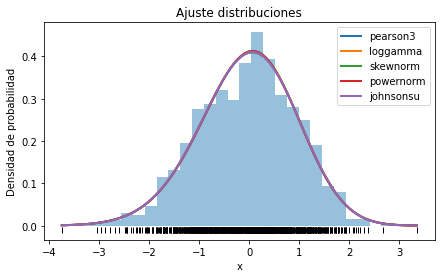



  distribucion  log_likelihood          aic          bic  n_parametros  \
0     pearson3    -1393.495956  2792.991913  2807.715179             3   
1     loggamma    -1393.567427  2793.134855  2807.858121             3   
2     skewnorm    -1393.759930  2793.519859  2808.243125             3   
3    powernorm    -1393.760372  2793.520744  2808.244010             3   
4    johnsonsu    -1393.561202  2795.122404  2814.753425             4   

                                          parametros  
0  {'skew': -0.20548574033784195, 'loc': -0.03523...  
1  {'c': 24.107921094344384, 'loc': -15.065748340...  
2  {'a': -1.229398691889185, 'loc': 0.73668820849...  
3  {'c': 2.9307537515428486, 'loc': 1.04638002000...  
4  {'a': 14.155760605052293, 'b': 12.030182363860...  

------------------------------------------------------------------


 ******************** Variable: Datos_E ******************** 

Error al tratar de ajustar la distribución loguniform
Optimization converged to parameters

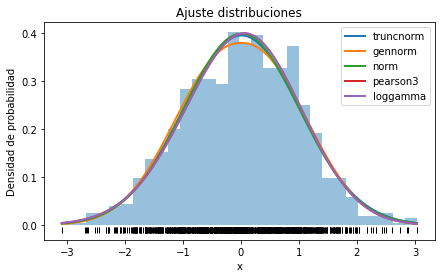



  distribucion  log_likelihood          aic          bic  n_parametros  \
0    truncnorm    -1415.126493  2838.252986  2857.884007             4   
1      gennorm    -1416.331561  2838.663122  2853.386388             3   
2         norm    -1417.471969  2838.943938  2848.759449             2   
3     pearson3    -1416.759243  2839.518485  2854.241751             3   
4     loggamma    -1416.790667  2839.581335  2854.304600             3   

                                          parametros  
0  {'a': -3.061254111268628, 'b': 2.9888238345532...  
1  {'beta': 2.230133808184206, 'loc': 0.004420449...  
2  {'loc': 0.01063171773736499, 'scale': 0.998534...  
3  {'skew': -0.09849342647680279, 'loc': 0.010613...  
4  {'c': 111.46892547254731, 'loc': -49.528328428...  

------------------------------------------------------------------


 ******************** Variable: Datos_Poisson_1 ******************** 



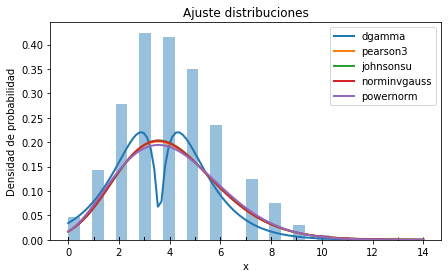



   distribucion  log_likelihood          aic          bic  n_parametros  \
0        dgamma    -2106.297438  4218.594877  4233.318143             3   
1      pearson3    -2108.645105  4223.290209  4238.013475             3   
2     johnsonsu    -2108.911789  4225.823578  4245.454599             4   
3  norminvgauss    -2108.924395  4225.848790  4245.479811             4   
4     powernorm    -2109.964533  4225.929067  4240.652333             3   

                                          parametros  
0  {'a': 1.7784484233699684, 'loc': 3.59882842649...  
1  {'skew': 0.5260062786632385, 'loc': 4.08296452...  
2  {'a': -10.568144043599705, 'b': 5.482645236066...  
3  {'a': 62.62419559891691, 'b': 56.9559219574444...  
4  {'c': 0.06744543292357016, 'loc': 0.9716515703...  

------------------------------------------------------------------


 ******************** Variable: Datos_Poisson_3 ******************** 



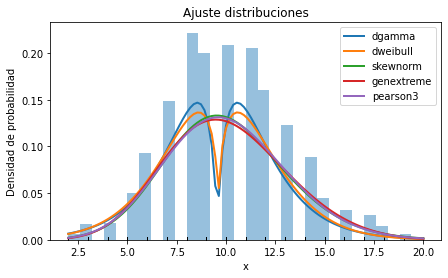



  distribucion  log_likelihood          aic          bic  n_parametros  \
0       dgamma    -2524.177514  5054.355028  5069.078293             3   
1     dweibull    -2529.634624  5065.269248  5079.992514             3   
2     skewnorm    -2532.416341  5070.832682  5085.555948             3   
3   genextreme    -2532.674925  5071.349849  5086.073115             3   
4     pearson3    -2532.906917  5071.813834  5086.537100             3   

                                          parametros  
0  {'a': 1.689396579600059, 'loc': 9.560170764181...  
1  {'c': 1.3474946146508602, 'loc': 9.60098310247...  
2  {'a': 1.5007390702926924, 'loc': 7.30875652488...  
3  {'c': 0.19937549184874834, 'loc': 8.8421311929...  
4  {'skew': 0.2774400278825916, 'loc': 10.0329554...  

------------------------------------------------------------------


 ******************** Variable: Datos_F ******************** 



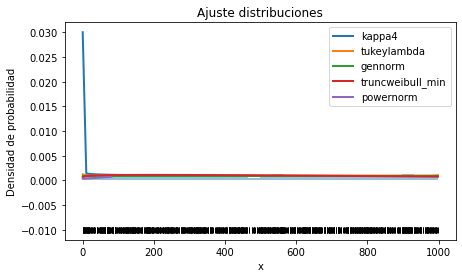



       distribucion  log_likelihood           aic           bic  n_parametros  \
0            kappa4    -6903.574568  13815.149135  13834.780156             4   
1       tukeylambda    -6905.446004  13816.892008  13831.615274             3   
2           gennorm    -6905.753356  13817.506711  13832.229977             3   
3  truncweibull_min    -6910.037223  13830.074446  13854.613223             5   
4         powernorm    -7059.204557  14124.409115  14139.132381             3   

                                          parametros  
0  {'h': 1.104941574259435, 'k': 0.98988552376114...  
1  {'lam': 1.0173193989600988, 'loc': 499.0006032...  
2  {'beta': 168713493.37284938, 'loc': 498.999997...  
3  {'c': 1.1158863371626504, 'a': 0.0008131243945...  
4  {'c': 9.019894827007048e-05, 'loc': -72.168716...  

------------------------------------------------------------------


 ******************** Variable: Datos_G ******************** 



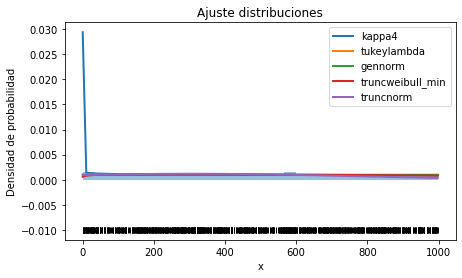



       distribucion  log_likelihood           aic           bic  n_parametros  \
0            kappa4    -6903.112838  13814.225675  13833.856696             4   
1       tukeylambda    -6905.613147  13817.226293  13831.949559             3   
2           gennorm    -6905.753498  13817.506995  13832.230261             3   
3  truncweibull_min    -6910.658433  13831.316865  13855.855642             5   
4         truncnorm    -7028.960233  14065.920467  14085.551488             4   

                                          parametros  
0  {'h': 1.104303799844521, 'k': 0.99218049803682...  
1  {'lam': 1.0053844994114058, 'loc': 499.0027540...  
2  {'beta': 63615492.855990514, 'loc': 499.000010...  
3  {'c': 1.1462898501526597, 'a': 0.0008953999574...  
4  {'a': -0.6837679661499794, 'b': 76099.05134263...  

------------------------------------------------------------------



In [20]:
ejemplo.comparar_distribuciones_caunti_cont()

## Quitar outlaiers

# PLOTS

In [21]:
#ejemplo.todos_plots()


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

-------------- Graficas de bigotes cualitativas-------------------


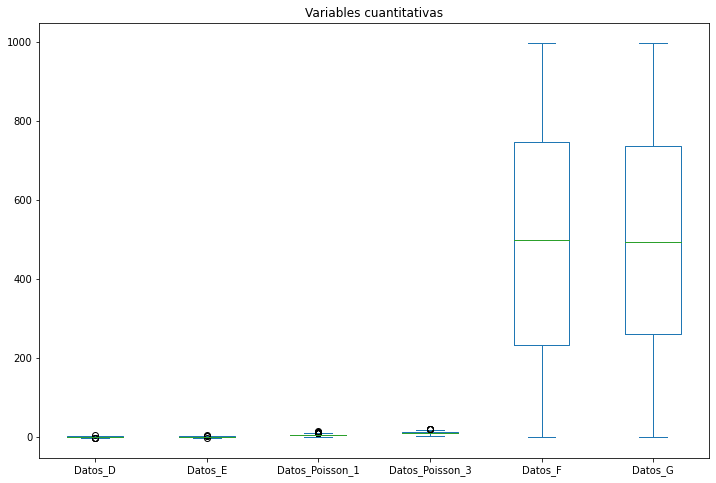

-------------- Graficas de bigotes por dicotomicas-------------------


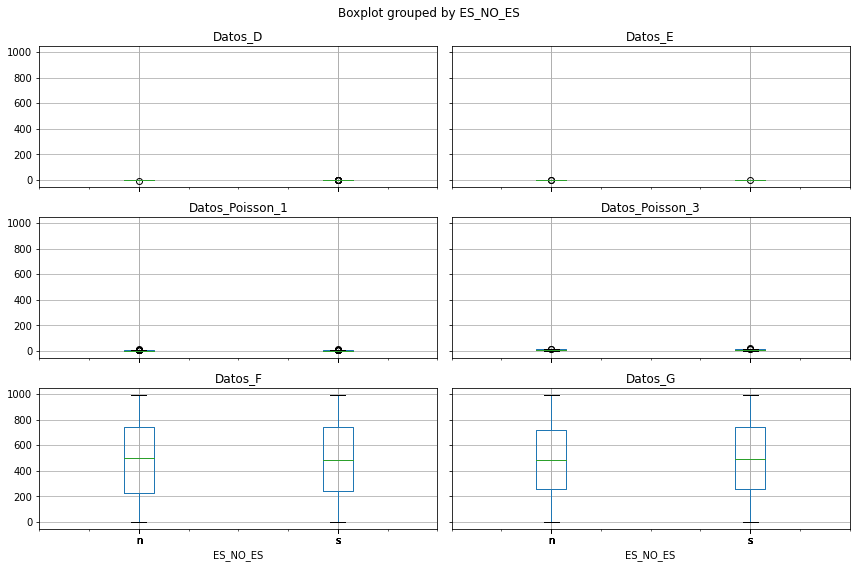

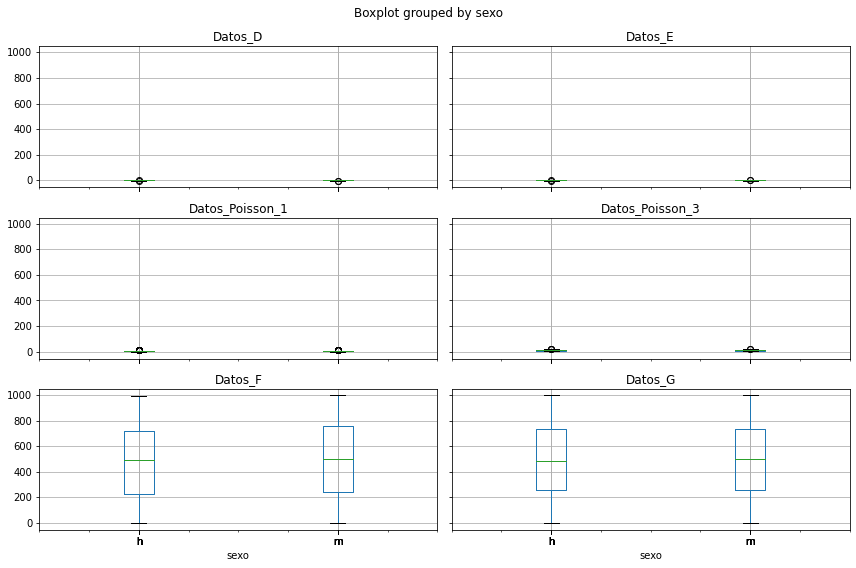

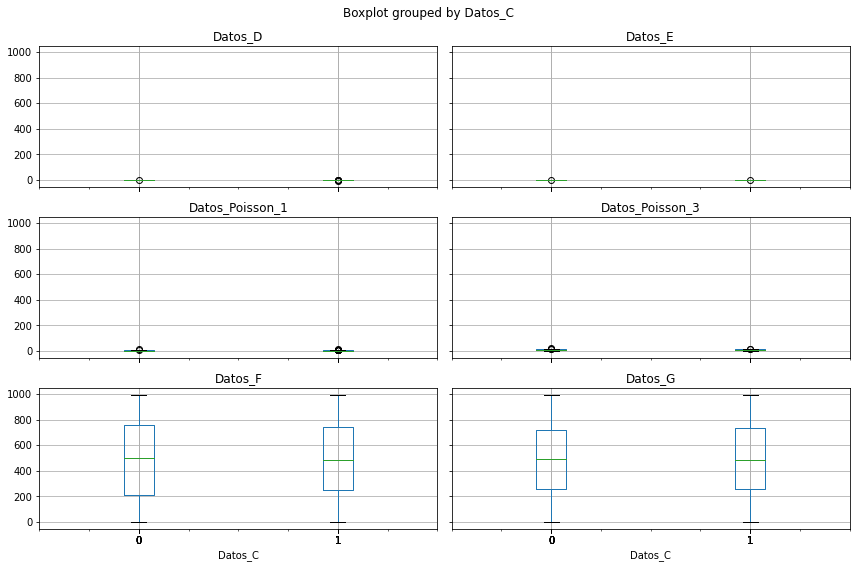



----------------------------------------------------------------------------------------------------

-------------- Graficas de bigotes por categoricas-------------------


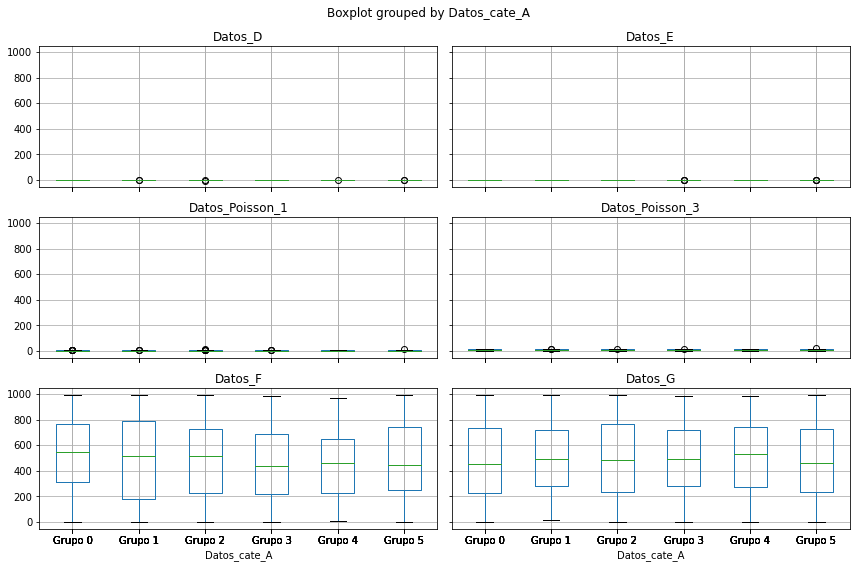

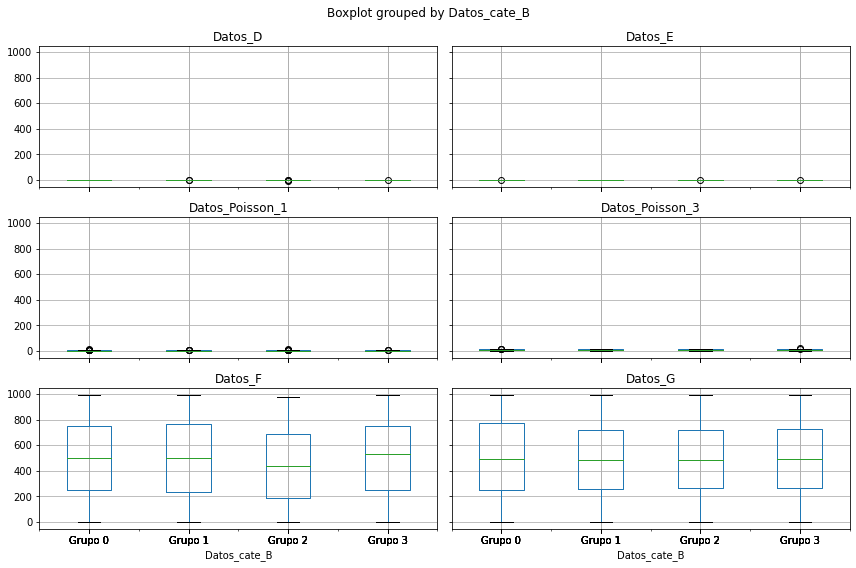



----------------------------------------------------------------------------------------------------


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [22]:
ejemplo.plot_bigotes()


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

----------------------------------------------------------------------------------------------------

-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------



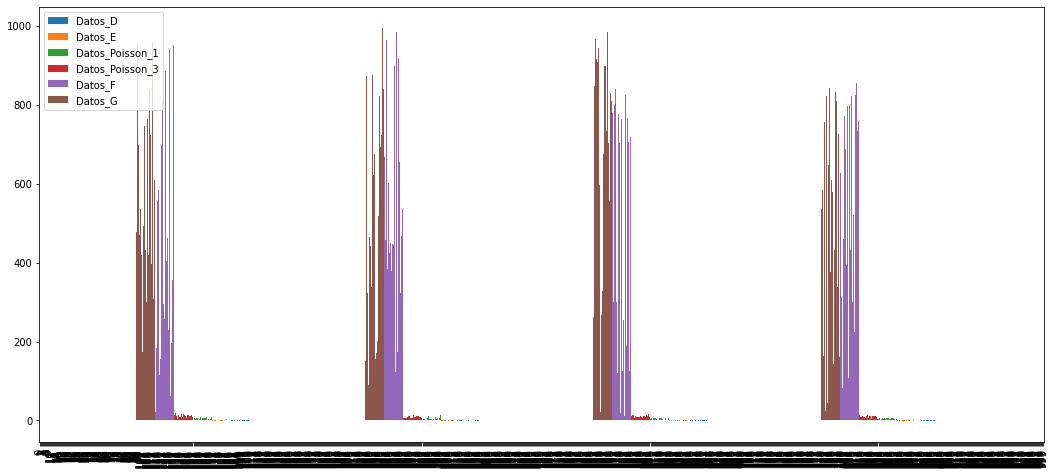

-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------


.............. GRAFICA DE BARRAS  DE Datos_D ............



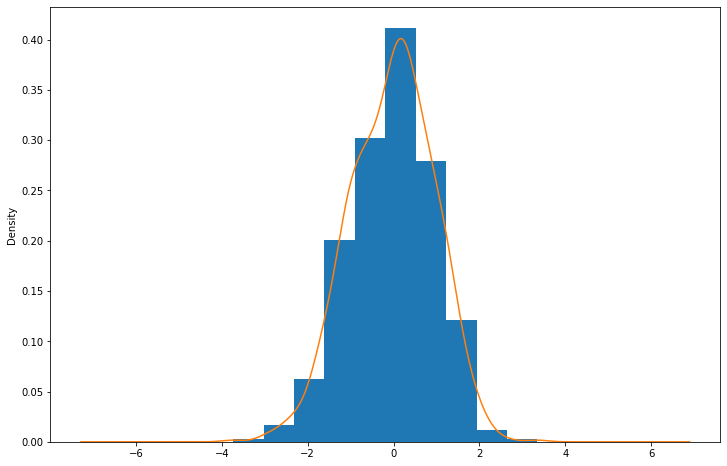


.............. GRAFICA DE BARRAS  DE Datos_E ............



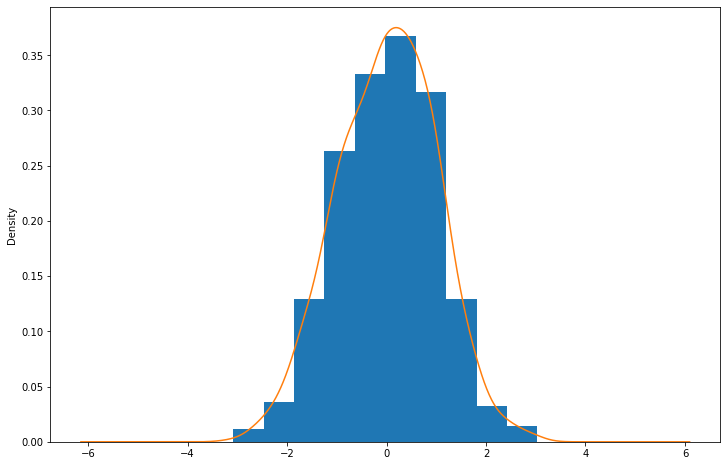


.............. GRAFICA DE BARRAS  DE Datos_Poisson_1 ............



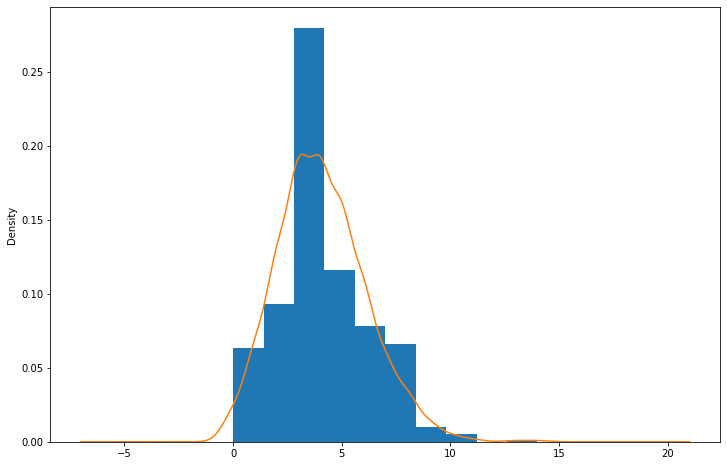


.............. GRAFICA DE BARRAS  DE Datos_Poisson_3 ............



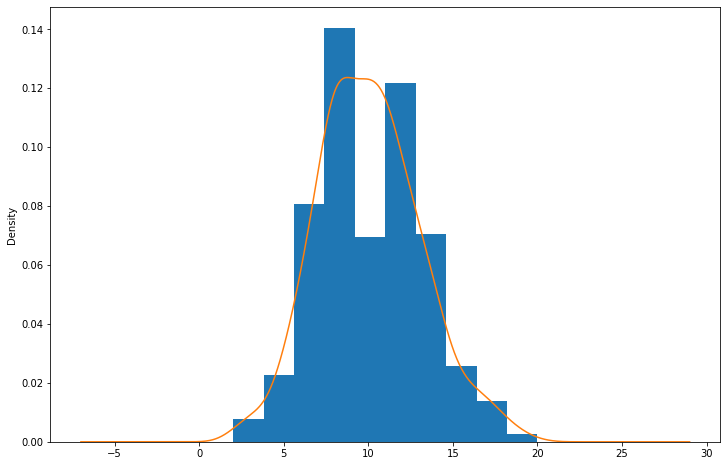


.............. GRAFICA DE BARRAS  DE Datos_F ............



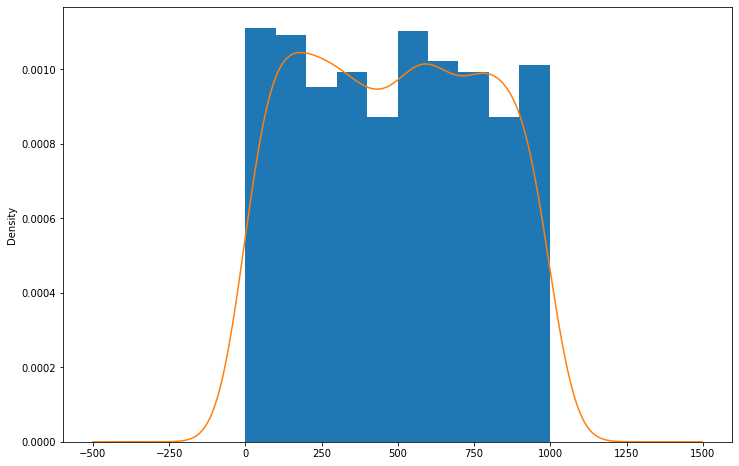


.............. GRAFICA DE BARRAS  DE Datos_G ............



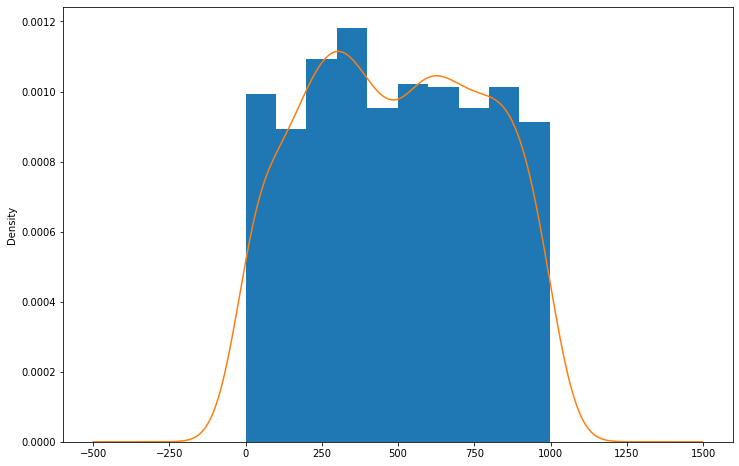

----------------------------------------------------------------------------------------------------


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [23]:
ejemplo.plot_barras()


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

----------------------------------------------------------------------------------------------------

-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------



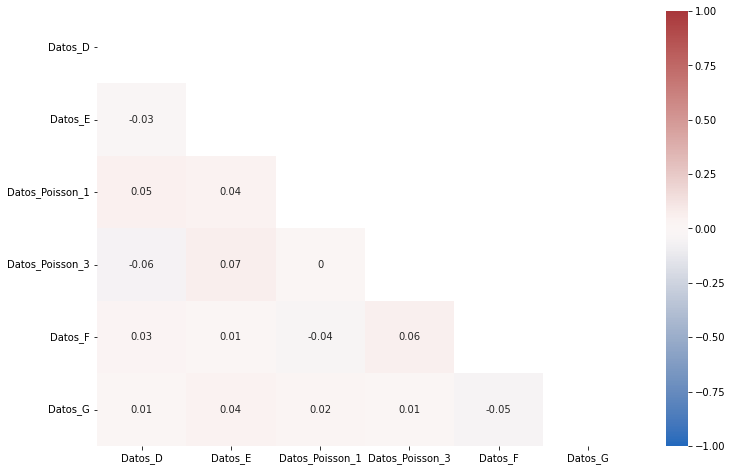

----------------------------------------------------------------------------------------------------


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [24]:
ejemplo.plot_corr()

--------------  GRAFICA DE VIOLINES  -------------------



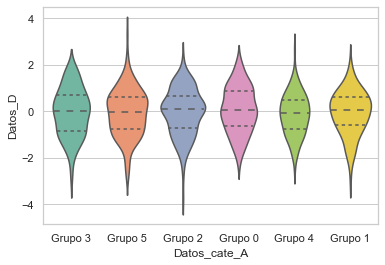

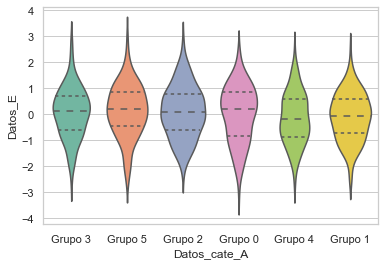

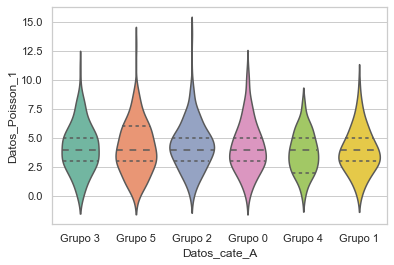

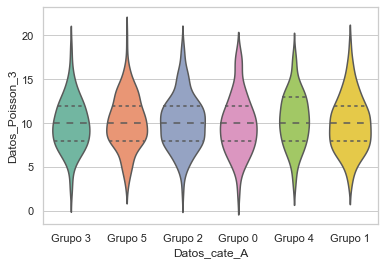

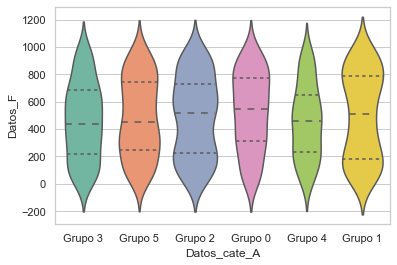

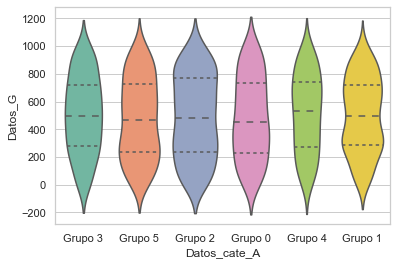

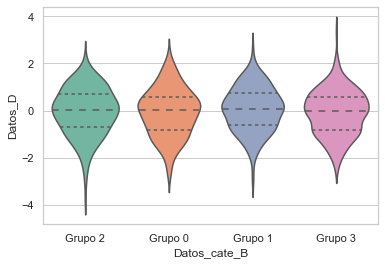

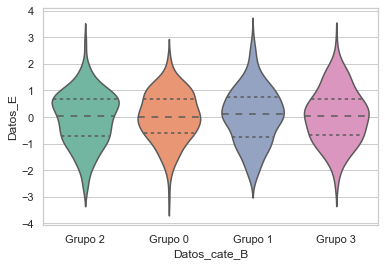

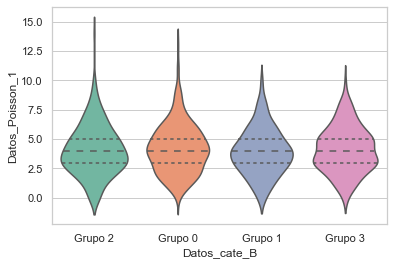

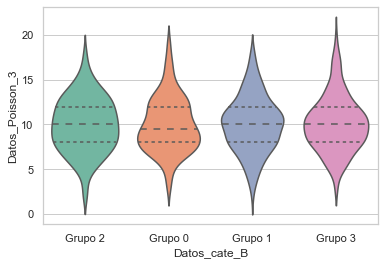

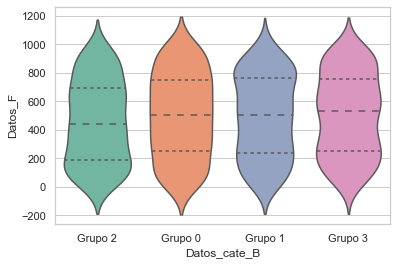

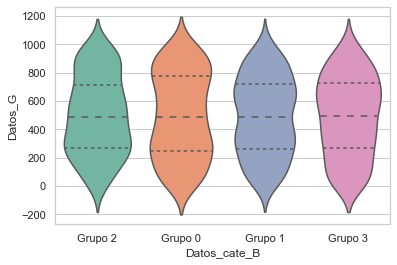



/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////



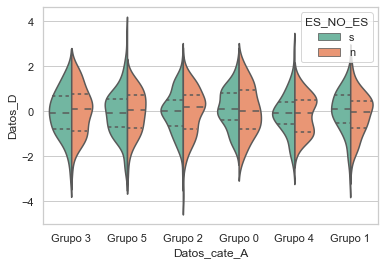

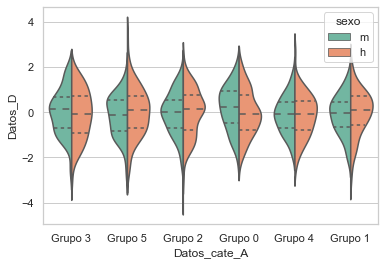

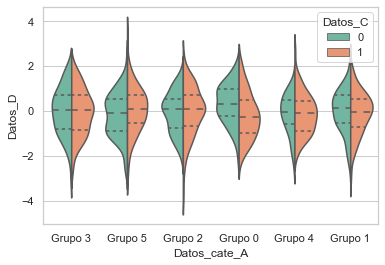

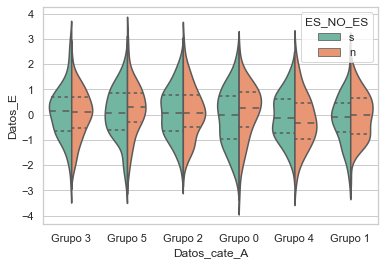

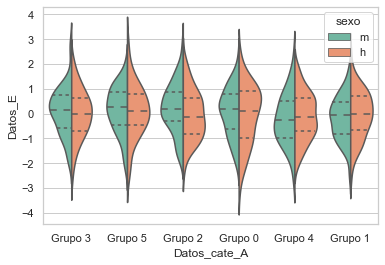

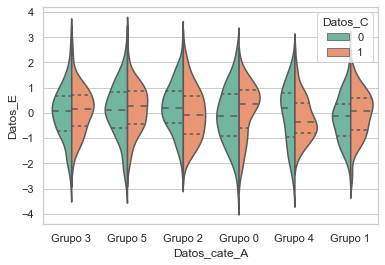

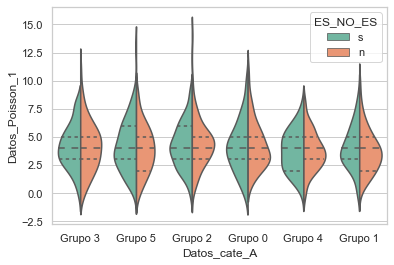

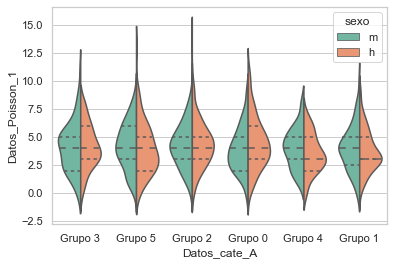

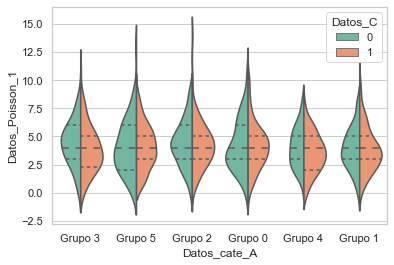

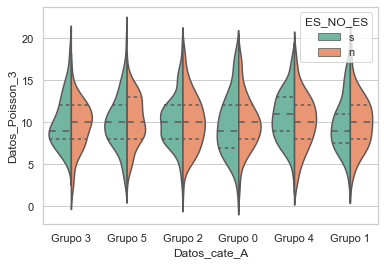

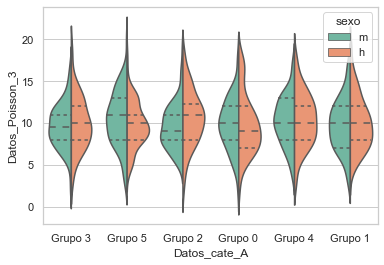

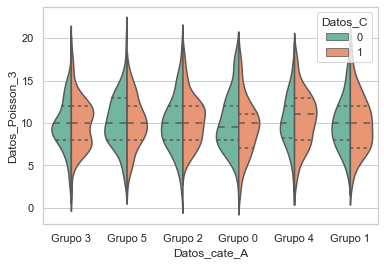

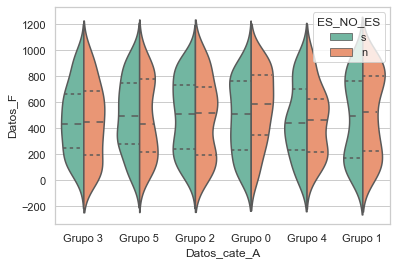

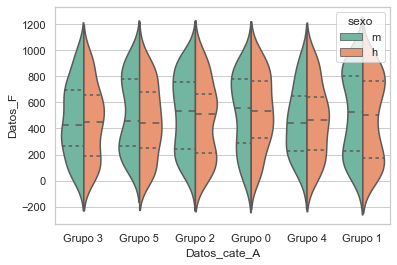

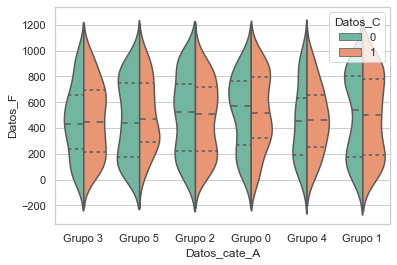

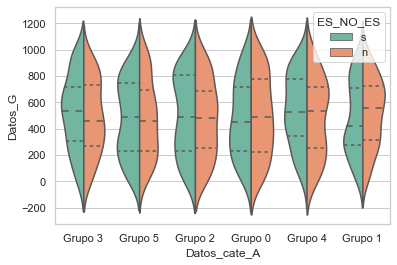

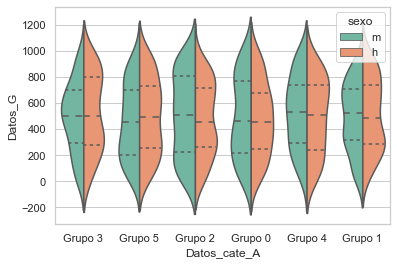

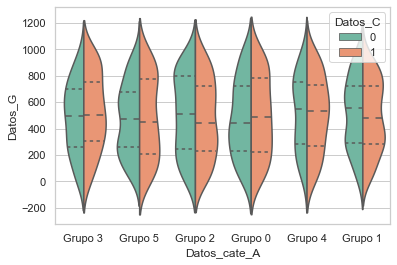

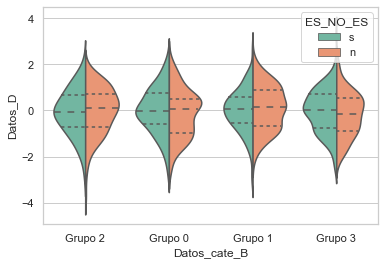

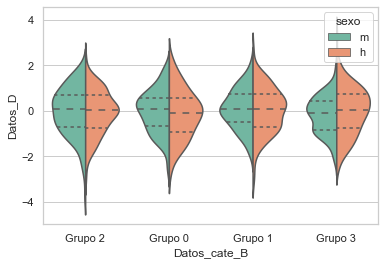

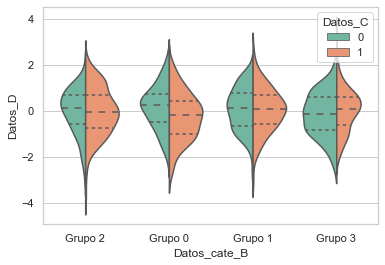

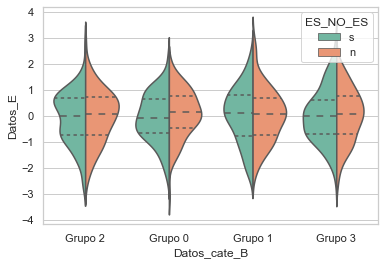

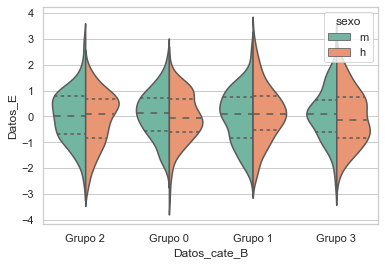

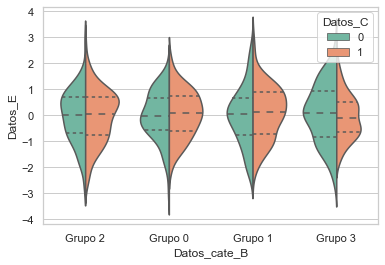

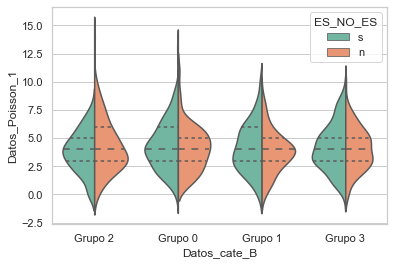

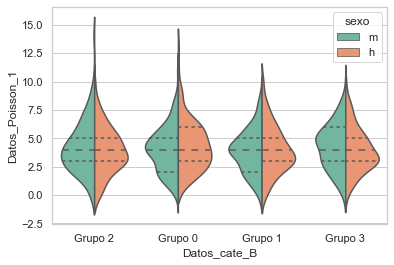

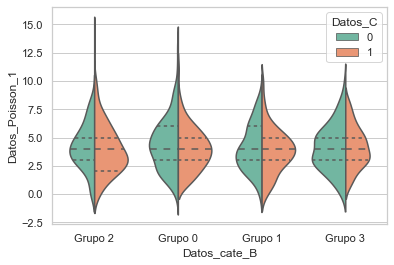

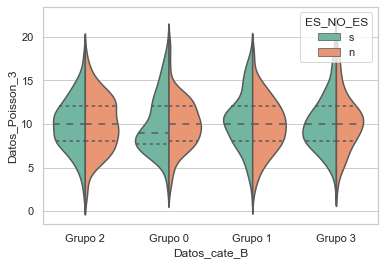

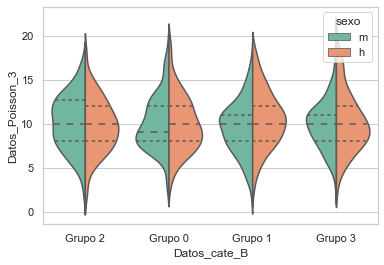

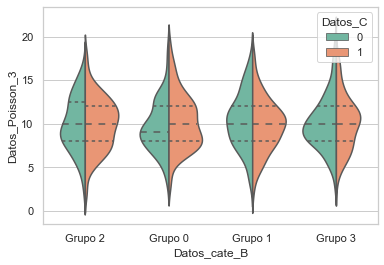

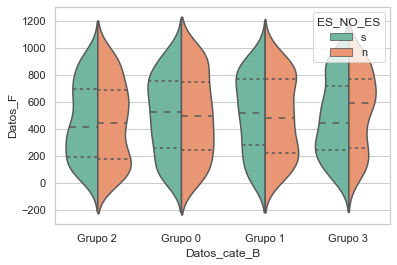

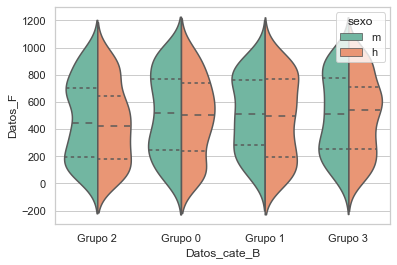

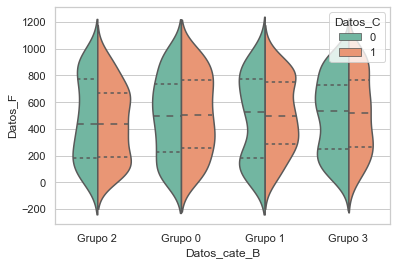

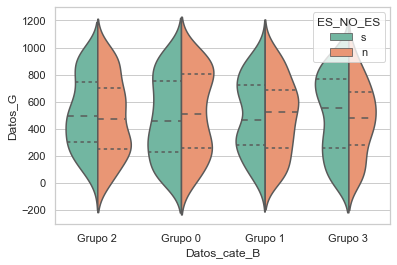

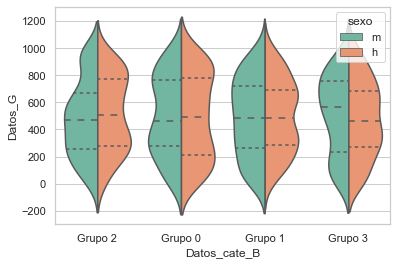

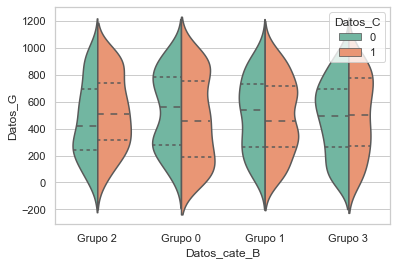

In [25]:
ejemplo.violines()

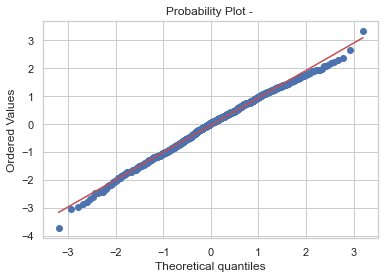

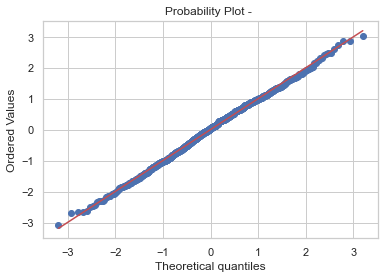

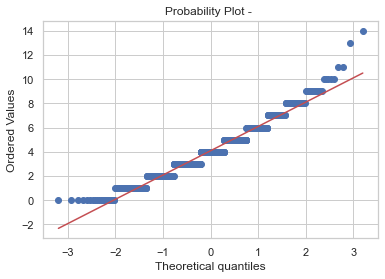

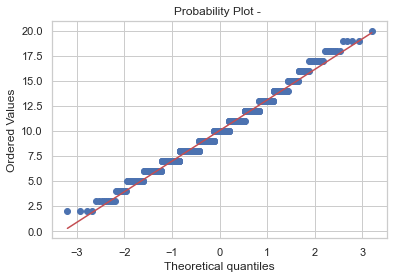

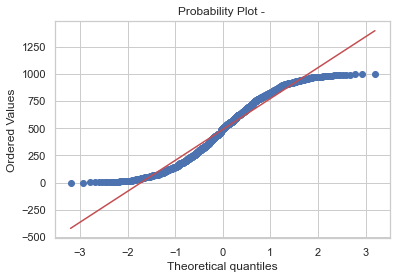

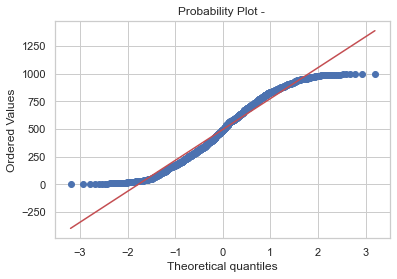

In [26]:
ejemplo.plot_normailidad()

# TEST ESTADISTICOS

## Chi2

In [27]:
ejemplo.Chi()


-------------- Chi2 entre ES_NO_ES y sexo ----------------
p: 0.9972745315629037 


-------------- Chi2 entre ES_NO_ES y Datos_C ----------------
p: 0.5625924554925692 


-------------- Chi2 entre sexo y Datos_C ----------------
p: 0.269615863500042 



## T_student

# Wilconxon

## Anova

In [28]:
ejemplo.anova()


----------- ANOVA Categoria Datos_cate_A y variable continua Datos_D ----------

                  sum_sq     df         F    PR(>F)
Datos_cate_A    3.031356    5.0  0.631858  0.675482
Residual      953.748538  994.0       NaN       NaN

----------- ANOVA Categoria Datos_cate_A y variable continua Datos_E ----------

                  sum_sq     df         F    PR(>F)
Datos_cate_A   10.090061    5.0  2.032363  0.071757
Residual      986.981107  994.0       NaN       NaN

----------- ANOVA Categoria Datos_cate_A y variable continua Datos_Poisson_1 ----------

                   sum_sq     df         F    PR(>F)
Datos_cate_A    35.721638    5.0  1.721821  0.126809
Residual      4124.389362  994.0       NaN       NaN

----------- ANOVA Categoria Datos_cate_A y variable continua Datos_Poisson_3 ----------

                   sum_sq     df         F    PR(>F)
Datos_cate_A    26.950082    5.0  0.571366  0.722016
Residual      9376.960918  994.0       NaN       NaN

----------- ANOVA Categor

In [29]:
# # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
# fvalue, pvalue = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])
# print(fvalue, pvalue)
# # 17.492810457516338 2.639241146210922e-05

# # get ANOVA table as R like output
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# # Ordinary Least Squares (OLS) model
# model = ols('value ~ C(treatments)', data=df_melt).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# anova_table
# # output (ANOVA F and p value)
#                 sum_sq    df         F    PR(>F)
# C(treatments)  3010.95   3.0  17.49281  0.000026
# Residual        918.00  16.0       NaN       NaN

# # ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
# from bioinfokit.analys import stat
# res = stat()
# res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
# res.anova_summary
# # output (ANOVA F and p value)
#                  df   sum_sq   mean_sq         F    PR(>F)
# C(treatments)   3.0  3010.95  1003.650  17.49281  0.000026
# Residual       16.0   918.00    57.375       NaN       NaN

# # note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# # (typ parameter) will produce similar results.

In [30]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
#  
# for x in categorical_col:
#     model = ols('cnt' + '~' + x, data = BIKE).fit() #Oridnary least square method
#     result_anova = sm.stats.anova_lm(model) # ANOVA Test
#     print(result_anova)

In [34]:
# aux=list(ejemplo.cuanti.columns)
# aux_DF=ejemplo.df_inputado
# for i in aux:
#     z = np.abs(stats.zscore(aux_DF[i]))
#     print(f"+++++++++{i}++++++++++++")
#     print(z)
df_prueba["Datos_Poisson_3"]

0      12
1      16
2       6
3       8
4       5
       ..
995    10
996    14
997     9
998     6
999     8
Name: Datos_Poisson_3, Length: 1000, dtype: int32

{'nbinom': 1.0, 'poisson': 0.0, 'geometric': 0.0}
Best fit: nbinom
Likelihood: 1.0


Best fit: nbinom
log_Likelihood: 0.0


AttributeError: 'nbinom_gen' object has no attribute 'fit'

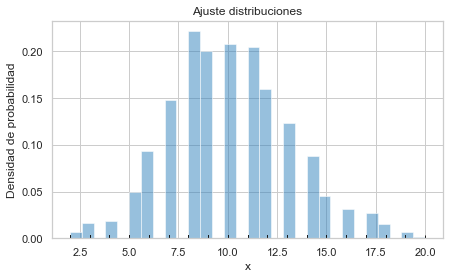

In [38]:
x=df_prueba["Datos_Poisson_3"]
mean = x.mean()
var = x.var()
likelihoods = {}  # we'll use it later
log_likelihoods = {}

p = 1 - mean / var  # : check for zero variance and limit p by [0, 1]
r = (1-p) * mean / p


likelihoods['nbinom'] = x.map(lambda val: stats.nbinom.pmf(val, r, p)).prod()
log_likelihoods['nbinom'] = x.map(lambda val: stats.nbinom.logpmf(val, r, p)).sum()

lambda_ = mean
likelihoods['poisson'] = x.map(lambda val:  stats.poisson.pmf(val, lambda_)).prod()
log_likelihoods['poisson'] = x.map(lambda val: stats.poisson.logpmf(val, r, p)).sum()

# mean = 1 / p  # this form fits the scipy definition
p = 1 / mean

likelihoods['geometric'] = x.map(lambda val:  stats.geom.pmf(val, p)).prod()
log_likelihoods['geometric'] = x.map(lambda val: stats.geom.logpmf(val, r, p)).sum()

best_fit = max(likelihoods, key=lambda x: likelihoods[x])
print(likelihoods)
print("Best fit:", best_fit)
print("Likelihood:", likelihoods[best_fit])

print("\n")

best_fit = max(log_likelihoods, key=lambda x: log_likelihoods[x])
print("Best fit:", best_fit)
print("log_Likelihood:", log_likelihoods[best_fit])

nombre_distribuciones=['nbinom','geometric','poisson']
fig, ax = plt.subplots(figsize=(7,4))
            
            
ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
ax.set_title('Ajuste distribuciones')
ax.set_xlabel('x')
ax.set_ylabel('Densidad de probabilidad')

for nombre in nombre_distribuciones:
    
    distribucion = getattr(stats, nombre)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                        if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)
    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)

ax.legend()
plt.show()


Optimization terminated successfully.
         Current function value: 2534.175693
         Iterations: 20
         Function evaluations: 40
mu_fit
10.03302001953125


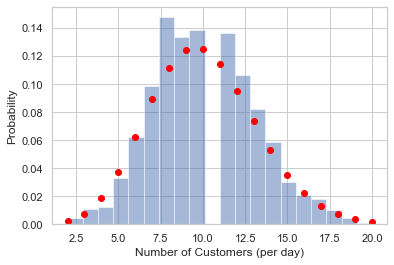

In [44]:
data=df_prueba["Datos_Poisson_3"]
plt.hist(data, bins=int(np.max(data)), density=True, alpha=0.5)

# plt.show()



def loss_function(params, data_in):

    mu = params[0]

    loss = 0

    for i in range(len(data_in)):

        loglikelihood = stats.poisson.logpmf(data_in[i], mu)

        loss_to_add = -loglikelihood

        loss += loss_to_add

    return(loss)



params0 = np.array([20])
minimum = stats2.optimize.fmin(loss_function, params0, args=(data,))

mu_fit = minimum[0]

print("mu_fit")
print(mu_fit)



x = list(range(int(np.min(data)), int(np.max(data))+1))
plt.scatter(x, stats.poisson.pmf(x, mu_fit),color="red")
plt.xlabel("Number of Customers (per day)")
plt.ylabel("Probability")
plt.show()